In [1]:
print("init...")
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
import itertools
import warnings
warnings.filterwarnings("ignore")
print("init done.")



init...
init done.


In [2]:
pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

            Deaths
Date              
2020-01-22       0
2020-01-23       0
2020-01-24       0
2020-01-25       0
2020-01-26       0
...            ...
2020-07-23   12873
2020-07-24   13026
2020-07-25   13172
2020-07-26   13249
2020-07-27   13334

[188 rows x 1 columns]


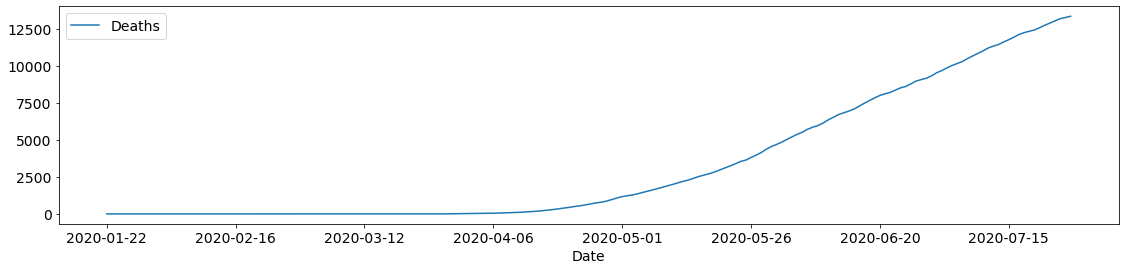

In [3]:
data=pd.read_csv("data/full_grouped.csv")
data=data.loc[data['Country/Region'] == "Russia"]
data.drop("Country/Region",1, inplace=True)
data.drop("WHO Region",1, inplace=True)
y=data.loc[:,["Date","Deaths"]]
y=y.set_index(["Date"])
print(y)
y.plot(figsize=(19,4))
plt.show()

In [4]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [5]:
arima=""
min_aic=9**10
min_arima=""
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            arima+='ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic)+"\n"
            if results.aic<min_aic:
                min_aic=results.aic
                min_arima='ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic)
        except: 
            continue
print(arima)
print("min aic",min_aic)
print("optimal arima", min_arima)

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:3748.195994934802
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:3421.7517126895887
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2979.6125113617736
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2602.0644523717974
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2728.772352615228
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2560.0573699200513
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2289.962180485791
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2247.211110665948
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:3595.3142677968417
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3339.3073343196256
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2729.558006161108
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2369.407815493571
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2495.6717695211255
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2324.3659804677327
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:2085.452967369999
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2069.489398941637
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2247.8911245238933
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1971.84323548259
AR

In [6]:
mod = sm.tsa.statespace.SARIMAX(y,order=(1, 1, 1),seasonal_order=(1, 1, 1, 12),enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9937      0.005    187.860      0.000       0.983       1.004
ma.L1         -0.6539      0.052    -12.541      0.000      -0.756      -0.552
ar.S.L12      -0.3127      0.058     -5.417      0.000      -0.426      -0.200
ma.S.L12      -1.0000      0.081    -12.332      0.000      -1.159      -0.841
sigma2       557.8817      0.000   3.84e+06      0.000     557.881     557.882


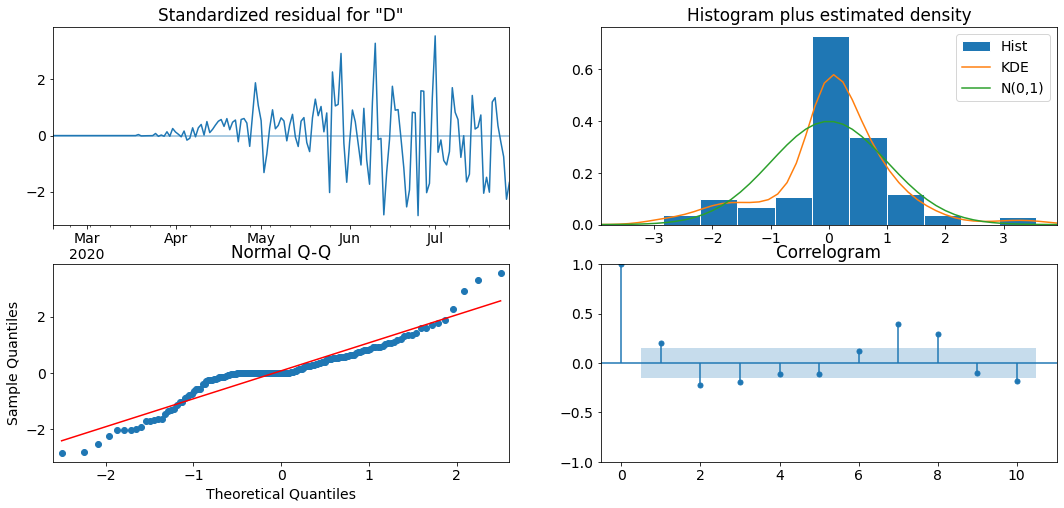

In [7]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

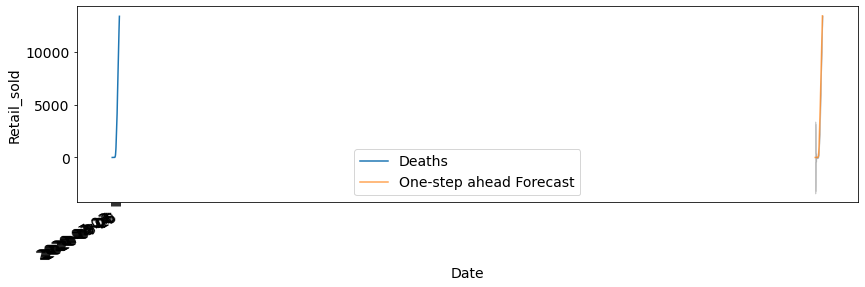

In [8]:
pred = results.get_prediction(dynamic=False) #start=pd.to_datetime('2020-07-23'), end=pd.to_datetime('2020-07-27')
pred_ci = pred.conf_int()
ax = y['2020':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Retail_sold')
plt.legend()
plt.show()
